In [0]:
# Install necessary packages -> uncomment what is currently needed

!pip install unidecode
!pip install contractions
!pip install wordsegment
!pip install -U symspellpy
!pip install emoji --upgrade
!pip install -U imbalanced-learn
!pip install bert-for-tf2
!pip install transformers
# !pip install nltk

     |████████████████████████████████| 245kB 6.3MB/s 
     |████████████████████████████████| 317kB 8.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81700 sha256=f5244711b1e0e42c0a358995733063df2709aff9d622fb6748526baca511b5e4
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 4.8MB 6.3MB/s 
     |████████████████████████████████| 2.6MB 6.4MB/s 
     |████████████████████████████████| 51kB 3.2MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=13c70be9a23ced82e568a71abddde5a9cf58e9337eb0009ab4b69d0db505db66
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     |████████████████████████████████| 163kB 6.3MB/s 
     |████████████████████████████████| 7.0MB 41.7MB/s 
  Found existing in

In [0]:
# All imports - DO NOT CHANGE THE ORDER OF INSTRUCTIONS
!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo

import re
import os
import sys
import json

if not 'bert_repo' in sys.path:
    sys.path.insert(0, 'bert_repo')

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
import spacy
from bs4 import BeautifulSoup
import unidecode
import contractions
import gensim.downloader as api
import re
import wordsegment
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity
import emoji
from imblearn.over_sampling import SMOTE
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from modeling import BertModel, BertConfig
from tokenization import FullTokenizer, convert_to_unicode
from extract_features import InputExample, convert_examples_to_features
from tqdm import tqdm
# import nltk
from google.colab import auth, drive
# nltk.download('punkt')

wordsegment.load()

# Load SymSpell -> package for correcting misspellings
sym_spell = SymSpell(2, 7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# get TF logger 
log = logging.getLogger('tensorflow')
log.handlers = []

Cloning into 'bert_repo'...
remote: Enumerating objects: 336, done.
remote: Total 336 (delta 0), reused 0 (delta 0), pack-reused 336
Receiving objects: 100% (336/336), 283.40 KiB | 948.00 KiB/s, done.
Resolving deltas: 100% (185/185), done.


Using TensorFlow backend.


In [0]:
#Import data
training_examples_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/olid-training-v1.0.tsv'
training_dataset = pd.read_csv(training_examples_url, delimiter='\t')
print(training_dataset.head())

      id                                              tweet  ... subtask_b subtask_c
0  86426  @USER She should ask a few native Americans wh...  ...       UNT       NaN
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...  ...       TIN       IND
2  16820  Amazon is investigating Chinese employees who ...  ...       NaN       NaN
3  62688  @USER Someone should'veTaken" this piece of sh...  ...       UNT       NaN
4  43605  @USER @USER Obama wanted liberals &amp; illega...  ...       NaN       NaN

[5 rows x 5 columns]


# **Training and validation sets**

In [0]:
training_examples, validation_examples = train_test_split(training_dataset, test_size=0.1)

# prepare training examples
training_examples_A = training_examples['tweet'][training_examples['subtask_a'].notnull()]
training_examples_B = training_examples['tweet'][training_examples['subtask_b'].notnull()]
training_examples_C = training_examples['tweet'][training_examples['subtask_c'].notnull()]

# prepare validation examples
validation_examples_A = validation_examples['tweet'][validation_examples['subtask_a'].notnull()]
validation_examples_B = validation_examples['tweet'][validation_examples['subtask_b'].notnull()]
validation_examples_C = validation_examples['tweet'][validation_examples['subtask_c'].notnull()]

# prepare training labels
training_labels_A = (training_examples['subtask_a'][training_examples['subtask_a'].notnull()] == 'OFF').astype(int)
training_labels_B = (training_examples['subtask_b'][training_examples['subtask_b'].notnull()] == 'TIN').astype(int)
c_mapping = {'IND': 0, 'GRP': 1, 'OTH': 2}
training_labels_C = training_examples['subtask_c'][training_examples['subtask_c'].notnull()].replace(c_mapping)

# prepare validation labels
validation_labels_A = (validation_examples['subtask_a'][validation_examples['subtask_a'].notnull()] == 'OFF').astype(int)
validation_labels_B = (validation_examples['subtask_b'][validation_examples['subtask_b'].notnull()] == 'TIN').astype(int)
validation_labels_C = (validation_examples['subtask_c'][validation_examples['subtask_c'].notnull()]).replace(c_mapping)


training_x = np.array(training_examples_A)
validation_x = np.array(validation_examples_A)
training_y = np.array(training_labels_A)
validation_y = np.array(validation_labels_A)

# **Preprocessing**

### Common preprocessing functions

In [0]:
# remove html tags if exist
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=' ')
    return stripped_text


# remove unnecessary whitespaces
def remove_whitespace(text):
    text = text.strip()
    return ' '.join(text.split())


# remove accented chars (e.g. caffè -> caffe)
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text


# remove hashes and split words (e.g. '#fortTrump' -> 'fort trump')
def split_hashtags(text):
    splitted = text.split()
    new_word_sequence = []

    for chunk in splitted:
        if chunk[0] == '#':
            chunk = chunk[1:]
            new_word_sequence.extend(wordsegment.segment(chunk))
        else:
            new_word_sequence.append(chunk)
        
    return ' '.join(tuple(new_word_sequence))


def substitute_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.compile('[_:]+').sub(' ', demojized_text)


def preprocess_common(text):
    text = strip_html_tags(text)
    text = contractions.fix(text)
    text = split_hashtags(text)
    text = substitute_emojis(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    return text.lower()

In [0]:
# Remove redundant @user tokens
def remove_redundant_users(example):
    user_count = 0
    new_example = example[:]
    for i, token in reversed(list(enumerate(example))):
        if token == '@user':
            user_count += 1
        if user_count > 3:
            new_example.pop(i)
    else:
        user_count = 0

    return new_example

### Spacy preprocessing

In [0]:
# Try leaving '?' and '!' as far as punctuation is concerned

nlp = spacy.load('en_core_web_sm')

# exclude negation words from spacy stopwords list
deselect_stop_words = ['no', 'not', 'noone', 'none', 'lacks', 'lack', 'nor', 'never', 'neighter', 'hardly', 'nobody', 'nothing', 'lacking', 'nowhere']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

def preprocess_spacy(text):
    doc = nlp(text)

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text

        # remove punctuations
        if token.pos_ == 'PUNCT' and flag == True and token.text != '@user': 
            flag = False
       
        # remove special characters
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
        
        # remove numbers
        if (token.pos_ == 'NUM' or token.text.isnumeric()) and flag == True:
            flag = False

        # correct misspelings
        if flag == True:
            suggestions = sym_spell.lookup(edit, Verbosity.TOP, 2)
            if len(suggestions) > 0:
                edit = suggestions[0].term

        # remove stop words
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False

        # convert tokens to base form
        elif token.lemma_ != '-PRON-' and flag == True:
            edit = token.lemma_

        # append tokens edited and not removed to list 
        if edit != '' and flag == True:
            clean_text.append(edit)        
    
    return clean_text

### Preprocessing execution

In [0]:
# normalization -> papers, complicated solutions, replace abbreviations with full names (e.g. MAGA)
# check removing less stop words (some may have some significance)

cleaned_x = [preprocess_spacy(example) for example in training_x[0:30]]
reduced_users_x = [remove_redundant_users(example) for example in cleaned_x]
print(reduced_users_x[0:30])
print(training_x[0:30])

[['@USER', 'peanut', 'farm', 'old', 'man'], ['@USER', '@USER', 'fish'], ['@USER', '@USER', 'stoned', 'Wheat', 'Crackers', 'hell', 'Stoned', 'Wheat', 'cracker'], ['@user', 'babe', 'hope', 'not', 'wonte', 'woman'], ['@USER', '@USER', '@USER', '@USER', '@USER', '@USER', 'popular', 'vote', 'terrible', 'democracy'], ['@user', 'good', 'booty', 'stunning', 'love', 'want', 'cum', 'deep'], ['@USER', '@USER', 'Corbyn', 'antisemitism', 'believe', 'way', 'racist', 'see', 'believe', 'antisemitism', 'go', 'leadership', 'continue', 'conservative', 'show', 'actively', 'support'], ['@USER', '@USER', 'of', 'bitch', 'psycho'], ['@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', 'follow', 'not', 'follow'], ['@USER', 'loot', 'money', 'repay', 'debt'], ['@USER', 'hope', 'not', 'block', 'Monday', 'want', 'page', '’s', 'reaction', 'Kavanaugh', 'get', 'confirm', 'Su

# **BERT**

### BERT Preprocessing - single example


In [0]:
def remove_punctation(tokens):
    punctuation = [char for char in string.punctuation]
    return list(filter(lambda token: token not in punctuation, tokens))


def preprocess_bert_before_tokenization(text):
    preprocessed_text = preprocess_common(text)
    spacy_x = preprocess_spacy(preprocessed_text)
    cleaned_x = remove_redundant_users(spacy_x)
    return ' '.join(cleaned_x)


def preprocess_bert_after_tokenization(tokenized_x):
    # update input_ids, input_mask, input_type_ids
    return remove_punctation(cleaned_x) # remove i.a. hyphens remainings from words like 'de-platforming'

### Getting the pre-trained model

In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2019-12-12 14:24:01--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 2a00:1450:400c:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   165MB/s    in 2.4s    

2019-12-12 14:24:03 (165 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


### Building a tf.Module

In [0]:
def build_module_fn(config_path, vocab_path, do_lower_case=True):

    def bert_module_fn(is_training):
        """Spec function for a token embedding module."""

        input_ids = tf.placeholder(shape=[None, None], dtype=tf.int32, name="input_ids")
        input_mask = tf.placeholder(shape=[None, None], dtype=tf.int32, name="input_mask")
        token_type = tf.placeholder(shape=[None, None], dtype=tf.int32, name="segment_ids")

        config = BertConfig.from_json_file(config_path)
        model = BertModel(config=config, is_training=is_training,
                          input_ids=input_ids, input_mask=input_mask, token_type_ids=token_type)
          
        seq_output = model.all_encoder_layers[-1]
        pool_output = model.get_pooled_output()

        config_file = tf.constant(value=config_path, dtype=tf.string, name="config_file")
        vocab_file = tf.constant(value=vocab_path, dtype=tf.string, name="vocab_file")
        lower_case = tf.constant(do_lower_case)

        tf.add_to_collection(tf.GraphKeys.ASSET_FILEPATHS, config_file)
        tf.add_to_collection(tf.GraphKeys.ASSET_FILEPATHS, vocab_file)
        
        input_map = {"input_ids": input_ids,
                     "input_mask": input_mask,
                     "segment_ids": token_type}
        
        output_map = {"pooled_output": pool_output,
                      "sequence_output": seq_output}

        output_info_map = {"vocab_file": vocab_file,
                           "do_lower_case": lower_case}
                
        hub.add_signature(name="tokens", inputs=input_map, outputs=output_map)
        hub.add_signature(name="tokenization_info", inputs={}, outputs=output_info_map)

    return bert_module_fn

### Exporting the module

In [0]:
MODEL_DIR = "uncased_L-12_H-768_A-12" #@param {type:"string"} ['uncased_L-12_H-768_A-12']

config_path = "/content/{}/bert_config.json".format(MODEL_DIR)
vocab_path = "/content/{}/vocab.txt".format(MODEL_DIR)

tags_and_args = []
for is_training in (True, False):
  tags = set()
  if is_training:
    tags.add("train")
  tags_and_args.append((tags, dict(is_training=is_training)))

module_fn = build_module_fn(config_path, vocab_path)
spec = hub.create_module_spec(module_fn, tags_and_args=tags_and_args)
spec.export("bert-module", 
            checkpoint_path="/content/{}/bert_model.ckpt".format(MODEL_DIR))


From bert_repo/modeling.py:171: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

From bert_repo/modeling.py:409: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
From bert_repo/modeling.py:490: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O relate

### Building the text preprocessing pipeline

In [0]:
def read_examples(str_list):
    """Read a list of `InputExample`s from a list of strings."""
    unique_id = 0
    for s in str_list:
        line = convert_to_unicode(s)
        if not line:
            continue
        
        text_a = line.strip()
        yield InputExample(unique_id=unique_id, text_a=text_a, text_b=None)
        unique_id += 1

In [0]:
def features_to_arrays(features):

    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []

    for feature in features:
        all_input_ids.append(feature.input_ids)
        all_input_mask.append(feature.input_mask)
        all_segment_ids.append(feature.input_type_ids)

    return (np.array(all_input_ids, dtype='int32'), 
            np.array(all_input_mask, dtype='int32'), 
            np.array(all_segment_ids, dtype='int32'))

In [0]:
def build_preprocessor(voc_path, seq_len, lower=True):
    tokenizer = FullTokenizer(vocab_file=voc_path, do_lower_case=lower)

    def strings_to_arrays(sents):

        sents = np.atleast_1d(sents).reshape((-1,))

        examples = []
        for example in read_examples(sents):
            example.text_a = preprocess_bert_before_tokenization(example.text_a)
            examples.append(example)

        features = convert_examples_to_features(examples, seq_len, tokenizer)
        arrays = features_to_arrays(features)
        
        return arrays

    return strings_to_arrays

### Implementing a BERT Keras layer

In [0]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_path, seq_len=64, n_tune_layers=3, 
                 pooling="cls", do_preprocessing=True, verbose=False,
                 tune_embeddings=False, trainable=True, **kwargs):

        self.trainable = trainable
        self.n_tune_layers = n_tune_layers
        self.tune_embeddings = tune_embeddings
        self.do_preprocessing = do_preprocessing

        self.verbose = verbose
        self.seq_len = seq_len
        self.pooling = pooling
        self.bert_path = bert_path

        self.var_per_encoder = 16
        if self.pooling not in ["cls", "mean", None]:
            raise NameError(
                f"Undefined pooling type (must be either 'cls', 'mean', or None, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.bert = hub.Module(self.build_abspath(self.bert_path), 
                               trainable=self.trainable, name=f"{self.name}_module")

        trainable_layers = []
        if self.tune_embeddings:
            trainable_layers.append("embeddings")

        if self.pooling == "cls":
            trainable_layers.append("pooler")

        if self.n_tune_layers > 0:
            encoder_var_names = [var.name for var in self.bert.variables if 'encoder' in var.name]
            n_encoder_layers = int(len(encoder_var_names) / self.var_per_encoder)
            for i in range(self.n_tune_layers):
                trainable_layers.append(f"encoder/layer_{str(n_encoder_layers - 1 - i)}/")
        
        # Add module variables to layer's trainable weights
        for var in self.bert.variables:
            if any([l in var.name for l in trainable_layers]):
                self._trainable_weights.append(var)
            else:
                self._non_trainable_weights.append(var)

        if self.verbose:
            print("*** TRAINABLE VARS *** ")
            for var in self._trainable_weights:
                print(var)

        self.build_preprocessor()
        self.initialize_module()

        super(BertLayer, self).build(input_shape)

    def build_abspath(self, path):
        if path.startswith("https://") or path.startswith("gs://"):
          return path
        else:
          return os.path.abspath(path)

    def build_preprocessor(self):
        sess = tf.keras.backend.get_session()
        tokenization_info = self.bert(signature="tokenization_info", as_dict=True)
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                              tokenization_info["do_lower_case"]])
        self.preprocessor = build_preprocessor(vocab_file, self.seq_len, do_lower_case)

    def initialize_module(self):
        sess = tf.keras.backend.get_session()
        
        vars_initialized = sess.run([tf.is_variable_initialized(var) 
                                     for var in self.bert.variables])

        uninitialized = []
        for var, is_initialized in zip(self.bert.variables, vars_initialized):
            if not is_initialized:
                uninitialized.append(var)

        if len(uninitialized):
            sess.run(tf.variables_initializer(uninitialized))

    def call(self, input):

        if self.do_preprocessing:
          input = tf.numpy_function(self.preprocessor, 
                                    [input], [tf.int32, tf.int32, tf.int32], 
                                    name='preprocessor')
          for feature in input:
            feature.set_shape((None, self.seq_len))
        
        input_ids, input_mask, segment_ids = input
        
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        output = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)
        
        if self.pooling == "cls":
            pooled = output["pooled_output"]
        else:
            result = output["sequence_output"]
            
            input_mask = tf.cast(input_mask, tf.float32)
            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            
            if self.pooling == "mean":
              pooled = masked_reduce_mean(result, input_mask)
            else:
              pooled = mul_mask(result, input_mask)

        return pooled

    def get_config(self):
        config_dict = {
            "bert_path": self.bert_path, 
            "seq_len": self.seq_len,
            "pooling": self.pooling,
            "n_tune_layers": self.n_tune_layers,
            "tune_embeddings": self.tune_embeddings,
            "do_preprocessing": self.do_preprocessing,
            "verbose": self.verbose
        }
        super(BertLayer, self).get_config()
        return config_dict

### Classification

In [0]:
inp = tf.keras.Input(shape=(1,), dtype=tf.string)
encoder = BertLayer(bert_path="./bert-module/", seq_len=256, tune_embeddings=False,
                    pooling='cls', n_tune_layers=3, verbose=False)

pred = tf.keras.layers.Dense(1, activation='sigmoid')(encoder(inp))

model = tf.keras.models.Model(inputs=[inp], outputs=[pred])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
model.summary()

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, ),
      loss="binary_crossentropy",
      metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
bert_layer_1 (BertLayer)     (None, 768)               109482240 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 769       
Total params: 109,483,009
Trainable params: 21,854,977
Non-trainable params: 87,628,032
_________________________________________________________________


### Training

In [0]:
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

In [0]:
saver = keras.callbacks.ModelCheckpoint("bert_256_64.hdf5")

history = model.fit(training_x, training_y, validation_data=[validation_x, validation_y], batch_size=64, epochs=2, callbacks=[saver])

Train on 11916 samples, validate on 1324 samples
Epoch 1/2
11916/11916 [==============================] - 357s 30ms/sample - loss: 0.4671 - acc: 0.7782 - val_loss: 0.4681 - val_acc: 0.7855
Epoch 2/2
11916/11916 [==============================] - 354s 30ms/sample - loss: 0.4393 - acc: 0.7963 - val_loss: 0.4609 - val_acc: 0.7772


### Loss function graph

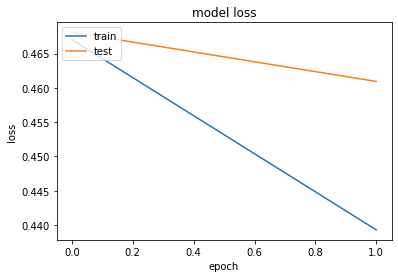

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving and restoring

In [0]:
print(training_y[11:20])
model.predict(training_x[11:20])

[0 0 0 0 1 1 0 0 1]


array([[0.1199744 ],
       [0.08535063],
       [0.46131864],
       [0.09784642],
       [0.5780003 ],
       [0.73423684],
       [0.03702918],
       [0.05184305],
       [0.85905075]], dtype=float32)

In [0]:
import json
json.dump(model.to_json(), open("model.json", "w"))

In [0]:
model = tf.keras.models.model_from_json(json.load(open("model.json")), 
                                        custom_objects={"BertLayer": BertLayer})

model.load_weights("bert_tuned.hdf5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


OSError: ignored

In [0]:
model.predict(training_x[:10])

### Freeze model

In [0]:
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.tools.optimize_for_inference_lib import optimize_for_inference

def freeze_keras_model(model, export_path=None, clear_devices=True):
    """
    Freezes a Keras model into a pruned computation graph.

    @param model The Keras model to be freezed.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    
    sess = tf.keras.backend.get_session()
    graph = sess.graph
    
    with graph.as_default():

        input_tensors = model.inputs
        output_tensors = model.outputs
        dtypes = [t.dtype.as_datatype_enum for t in input_tensors]
        input_ops = [t.name.rsplit(":", maxsplit=1)[0] for t in input_tensors]
        output_ops = [t.name.rsplit(":", maxsplit=1)[0] for t in output_tensors]
        
        tmp_g = graph.as_graph_def()
        if clear_devices:
            for node in tmp_g.node:
                node.device = ""
        
        tmp_g = optimize_for_inference(
            tmp_g, input_ops, output_ops, dtypes, False)
        
        tmp_g = convert_variables_to_constants(sess, tmp_g, output_ops)
        
        if export_path is not None:
            with tf.gfile.GFile(export_path, "wb") as f:
                f.write(tmp_g.SerializeToString())
        
        return tmp_g

In [0]:
frozen_graph = freeze_keras_model(model, export_path="frozen_graph_256_64.pb")

In [0]:
!git clone https://github.com/gaphex/bert_experimental/

import tensorflow as tf
import numpy as np
import sys

sys.path.insert(0, "/content/bert_experimental")

from bert_experimental.finetuning.text_preprocessing import build_preprocessor
from bert_experimental.finetuning.graph_ops import load_graph

In [0]:
restored_graph = load_graph("frozen_graph.pb")

In [0]:
graph_ops = restored_graph.get_operations()
input_op, output_op = graph_ops[0].name, graph_ops[-1].name
print(input_op, output_op)

In [0]:
x = restored_graph.get_tensor_by_name(input_op + ':0')
y = restored_graph.get_tensor_by_name(output_op + ':0')

In [0]:
preprocessor = build_preprocessor("./uncased_L-12_H-768_A-12/vocab.txt", 64)
py_func = tf.numpy_function(preprocessor, [x], [tf.int32, tf.int32, tf.int32], name='preprocessor')

In [0]:
py_func = tf.numpy_function(preprocessor, [x], [tf.int32, tf.int32, tf.int32])

In [0]:
sess = tf.Session(graph=restored_graph)

In [0]:
y_out = sess.run(y, feed_dict={
        x: training_x[:10].reshape((-1,1))
    })

y_out